In [1]:
from IPython.display import HTML

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">TOGGLE CODE CELLS ON/OFF</a>.''')

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

Notebook that verifies the following:
- The area under the ROC curve for the 1-interval task is P(correct) on the corresponding 2-interval task.

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special
%matplotlib inline

In [4]:
font = {'size'   : 20}

matplotlib.rc('font', **font)

In [28]:
stim_vals = np.linspace(-8, 8, num=1000)
mu_noise = -1
mu_signal = 1
std_noise = 1.4
std_signal = 1.4
assert std_noise == std_signal
def set_mu(snr):
    # std assumed to be 1
    ms = snr / 2  # signal mean
    mn = -ms      # noise mean
    return mn, ms

In [6]:
def my_norm_pdf(x, mu, sigma):
    return 1/(sigma * np.sqrt(2 * np.pi)) *  np.exp(-(x - mu)**2 / (2 * sigma**2))
def noise_pdf(x):
    return my_norm_pdf(x, mu_noise, std_noise)
def signal_pdf(x):
    return my_norm_pdf(x, mu_signal, std_signal)

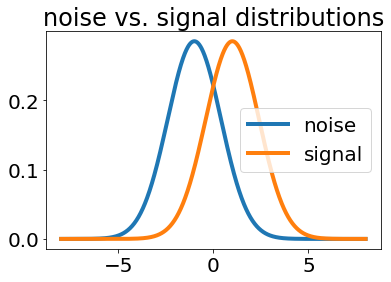

In [7]:
plt.plot(stim_vals, noise_pdf(stim_vals), stim_vals, signal_pdf(stim_vals), linewidth=4)
plt.legend(['noise', 'signal'])
plt.title('noise vs. signal distributions');

In [8]:
def build_1_interval_ROC_curve(noise_dist, signal_dist, stim_space):
    """
    noise_dist and signal_dist are functions of a single variable, they must be pdfs.
    stim_space is the set of criterion values to span
    """
    def prob_above(pdf, value):
        """pdf is a callable pdf function of a single variable"""
        result = integrate.quad(lambda x: pdf(x), value, np.inf)
        return result[0]
    
    curve_x, curve_y = [], []
    for s in stim_space:
        # P(FA)
        curve_x.append(prob_above(noise_dist, s)) 
        # P(Hit)
        curve_y.append(prob_above(signal_dist, s))
    return np.sort(np.array(curve_x)), np.sort(np.array(curve_y))

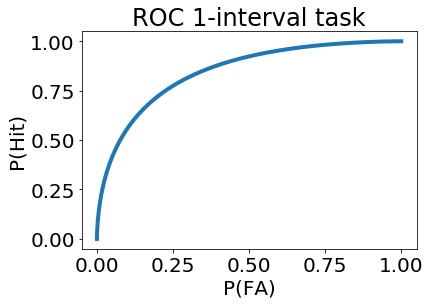

In [9]:
p_fa, p_hit = build_1_interval_ROC_curve(noise_pdf, signal_pdf, stim_vals)
plt.plot(p_fa, p_hit, linewidth=4)
plt.xlabel('P(FA)')
plt.ylabel('P(Hit)')
plt.title('ROC 1-interval task');

Estimate of area under ROC 1-interval curve.

In [10]:
area = integrate.simps(p_hit, p_fa)

In [11]:
print(area)

0.8437886080072389


Estimating P(Correct) on 2-interval task

In [12]:
def estimate_2_interval_pcorrect(dist_1, dist_2, num_sims):
    
    # generate num_sims samples (i.e. trials) from each distribution
    noise_samples = dist_1(num_sims)  # noise distribution
    signal_samples = dist_2(num_sims)  # signal distribution
    
    # assign randomly each sample to interval 1 or interval 2
    # the array below contains 1 every time the signal sample was assigned to interval 2
    trials_signal_in_2 = np.random.binomial(1, 0.5, size=num_sims) 
    
    # symmetric of the above
    trials_signal_in_1 = 1 - trials_signal_in_2
    
    # list of (interval_1, interval_2) samples
    trials = []
    for sim in range(num_sims):
        if trials_signal_in_2[sim]:
            trials.append((noise_samples[sim], signal_samples[sim]))
        else:
            trials.append((signal_samples[sim], noise_samples[sim]))
    
    # when subject chooses "signal present in interval 2" 
    sample_2_greater = np.array([d[1] > d[0] for d in trials])
    
    # check no ambiguous trials were generated
    assert all([d[0] != d[1] for d in trials])
    
    # when subject chooses "signal present in interval 1" 
    sample_1_greater = np.array([d[0] > d[1] for d in trials]) 
    
    # count the hit trials
    num_1_hits = np.sum(trials_signal_in_1 * sample_1_greater)
    num_2_hits = np.sum(trials_signal_in_2 * sample_2_greater)
    
    return (num_1_hits + num_2_hits) / num_sims

In [13]:
def generate_noise_samples(n):
    return np.random.normal(loc=mu_noise, scale=std_noise, size=n)
def generate_signal_samples(n):
    return np.random.normal(loc=mu_signal, scale=std_signal, size=n)

In [14]:
p_correct_estimate = estimate_2_interval_pcorrect(generate_noise_samples, generate_signal_samples, 5000000)

In [15]:
print(f'area under 1-interval ROC: {area:.5f}; Estimate of 2-interval P(Correct): {p_correct_estimate:.5f}')

area under 1-interval ROC: 0.84379; Estimate of 2-interval P(Correct): 0.84404


Open question remaining: what is the functional relationship between P(correct) on the 2-interval task and P(correct) on the 1-interval task? So far we just know that the former is greater than the latter.

Let's plot P(Correct) from the 2-interval task as a function of P(Correct) on the 1-interval task.

In [16]:
def estimate_p_correct_1_interval(criterion, num_sims, signal_sample, noise_sample):
    # decide which trials have the signal
    signal_trials = np.random.binomial(1,.5,size=num_sims)
    
    # generate samples on each trial and get subject's choice
    samples, choices, correct = [], [], []

    for trial in range(num_sims):
        is_signal_trial = bool(signal_trials[trial])
        sample = signal_sample() if is_signal_trial else noise_sample()
        samples.append(sample)
        choice = sample > criterion
        choices.append(choice)
        correct.append((choice and is_signal_trial) or (not(choice) and not(is_signal_trial)))
    
    return sum(correct) / num_sims

In [17]:
one_interval_pcorrect = estimate_p_correct_1_interval(0, 1000000, 
                                                      lambda: generate_signal_samples(1), 
                                                      lambda: generate_noise_samples(1))

In [18]:
print(f'P(Corr) 1-int {one_interval_pcorrect:.4f}, sqrt(2)*P(Corr)={np.sqrt(2)*one_interval_pcorrect:.4f}, P(Corr) 2-int={p_correct_estimate:.4f}')

P(Corr) 1-int 0.7625, sqrt(2)*P(Corr)=1.0783, P(Corr) 2-int=0.8440


In [29]:
def run_sims(ns, snr_list):
    pcorr_1interv, pcorr_2interv = [], []
    for s in snr_list:
        mun, mus = set_mu(s)
        def gn_samples(n):
            return np.random.normal(loc=mun, scale=1, size=n)
        def gs_samples(n):
            return np.random.normal(loc=mus, scale=1, size=n)
        pcorr_1interv.append(estimate_p_correct_1_interval(0, ns, 
                                                           lambda: gs_samples(1),
                                                           lambda: gn_samples(1)))
        
        pcorr_2interv.append(estimate_2_interval_pcorrect(gn_samples, gs_samples, 
                                                          ns))
    return pcorr_1interv, pcorr_2interv

In [37]:
snrs = [.2, .5, .8, 1.2, 1.5, 1.8, 2, 3.5, 4]
x, y = run_sims(1000000, snrs)

In [39]:
new_snrs = list(np.linspace(2.1,3.3,4))

In [40]:
new_x, new_y = run_sims(1000000, new_snrs)

In [41]:
x += new_x
y += new_y

(0.5, 1)

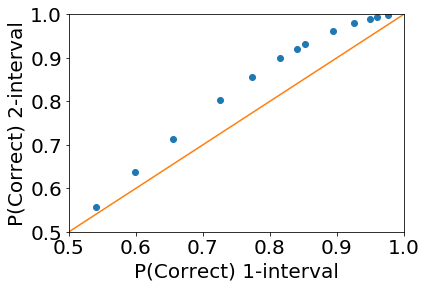

In [45]:
plt.plot(x, y, 'o')
plt.xlabel('P(Correct) 1-interval')
plt.ylabel('P(Correct) 2-interval')
plt.plot([.5,1], [.5,1])
# plt.plot(np.linspace(.5,1), np.sqrt(np.linspace(.5,1)))
plt.xlim([.5,1])
plt.ylim([.5,1])